In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

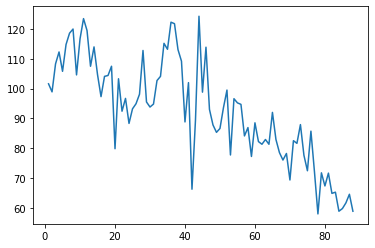

In [2]:
series = np.loadtxt("seriesautos.txt", dtype=np.float32)
time = np.arange(1, 89)
plt.plot(time, series)

In [3]:
split_time = 84
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
window_size = 10
batch_size = 16
shuffle_buffer_size = 50
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<100):
      print("\nYa se alcanzó una 'loss' igual a 100 entonces paramos!")
      self.model.stop_training = True

callbacks = myCallback()

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential([
  Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  LSTM(60, return_sequences=True), 
  LSTM(60, return_sequences=True),
  Dense(30, activation="relu"), 
  Dense(10, activation="relu"),
  Dense(1), 
  Lambda(lambda x: x * 100)
])

model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
5/5 [==============================] - 1s 108ms/step - loss: 6273.0889 - mae: 77.2938
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 2135.8696 - mae: 38.8680
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 1365.5881 - mae: 30.1320
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 957.2264 - mae: 25.4132
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 565.9843 - mae: 17.5186
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 474.0812 - mae: 16.8425
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 394.4659 - mae: 16.0134
Epoch 8/100
5/5 [==============================] - 0s 13ms/step - loss: 345.5011 - mae: 15.3715
Epoch 9/100
5/5 [==============================] - 0s 13ms/step - loss: 282.3914 - mae: 13.8952
Epoch 10/100
5/5 [==============================] - 0s 13ms/step - loss: 265.8201 - mae: 13.2598
Epoch 11/100
5/5 [=================

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

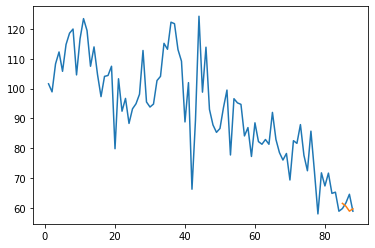

In [10]:
plt.plot(time, series)
plt.plot(time_valid, rnn_forecast)

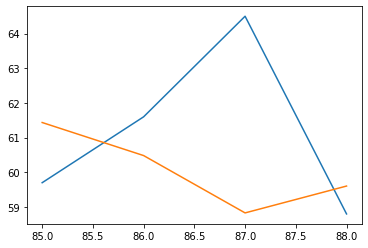

In [11]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)